# Data Cleaning
This notebook includes analysis with regards to the data cleaning step that is taken for the earthquake damage dataset.

In [1]:
# enables referencing modules in repository
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat

from scipy.stats import chi2_contingency

from src.features import build_features
# from src.data import make_dataset 
# commented out because: there seems to be an issue at the moment with the initial method from make_dataset
from src.models import train_model
from src.models import predict_model
from src.visualization import visualize
from tabulate import tabulate
from scipy import stats

In [2]:
# Loading the data
train_df = pd.read_csv('../data/raw/train_values.csv')

## Determining the type of features
From the exploratory data analysis the following descriptions of the features have been derived:

1. `building_id` seems to be used to identify each unique building.
2. `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id` these features seem to describe the location the building is located in.
3. `count_floors_pre_eq` seems to be the number of floors the building had before the earthquake happend
4. `age` seems to be the age of the building before it was destroyed
5. `area_percentage` maybe the amount of buildings in an area 
6. `height_percentage` likely the height of the building before it was destroyed
7. `land_surface_condition` likely the condition the surface of the ground of the building had before the earthquake
8. `foundation_type` as the name suggests this seems to be the type of the foundation the building was built 
9. `roof_type`, `ground_floor_type`, `other_floor_type` as the name suggest this seems to be the type of the roof and floors the building had. It seems like only to types of floors where recorded
10. `position` (unkown)
11. `plan_configuration` likely class of building structure
12. `has_superstructure..` likely a one hot encoded feature that represents the type of used superstructure
13. `legal_ownership_status` likely who the building belongs to
14. `count_families` seems to be the amount of families that lived in the building
15. `has_secondary_use..` seems to describe whether the building had an additional purpose than living in it

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

Although most features have the int64 datatype which could suggest that these features are numerical, judging by the meaning and values from the exploratory data analysis there are features that are numerically encoded but have a categorical meaning. 

Therefore for the future analysis we categorize the features by `categorical` and `numerical` by hand. The following lists are created with regard to the feature analysis done in the exploration step.

In [3]:
categorical_columns = [
        'building_id',
        'geo_level_1_id',
        'geo_level_2_id',
        'geo_level_3_id',
        'count_floors_pre_eq',
        'land_surface_condition',
        'foundation_type',
        'roof_type',
        'ground_floor_type',
        'other_floor_type',
        'position',
        'plan_configuration',
        'has_superstructure_adobe_mud',
        'has_superstructure_mud_mortar_stone',
        'has_superstructure_stone_flag',
        'has_superstructure_cement_mortar_stone',
        'has_superstructure_mud_mortar_brick',
        'has_superstructure_cement_mortar_brick',
        'has_superstructure_timber',
        'has_superstructure_bamboo',
        'has_superstructure_rc_non_engineered',
        'has_superstructure_rc_engineered',
        'has_superstructure_other',
        'legal_ownership_status',
        'has_secondary_use',
        'has_secondary_use_agriculture',
        'has_secondary_use_hotel',
        'has_secondary_use_rental',
        'has_secondary_use_institution',
        'has_secondary_use_school',
        'has_secondary_use_industry',
        'has_secondary_use_health_post',
        'has_secondary_use_gov_office',
        'has_secondary_use_use_police',
        'has_secondary_use_other'
    ]

numerical_columns = [
    'age',
    'area_percentage',
    'height_percentage',
    'count_families'
    ]

## Finding Outliers in the dataset
---

### Strategies for finding Outliers
The following strategies are used for outlier analysis in this notebook.
#### 1. interquartile range (IQR)
IQR is the difference between the 75th percentile (Q3) and the 25th percentile (Q1). Using the IQR, the outlier data points are the ones falling below Q1–1.5 IQR or above Q3 + 1.5 IQR. 

Where Q1 is the 25th percentile and Q3 is the 75th percentile of the dataset, and IQR represents the interquartile range calculated by Q3 minus Q1 (Q3–Q1). 

#### 2. Boxplot
With the help of a boxplot it is possible to visually inspect the data for the presence of outliers. If there are outliers in the data, they will be represented as points outside the whiskers of the box plot.

### 3. Z-Score
The Z-Score helps to understand whether a data value is greater or smaller than the mean and how far away it is from the mean.

### Strategies for handeling outliers
The following strategies are used for handling the outliers that have been found.
#### 1. Dropping the data row including the outlier
With this method all data rows are dropped that include values that have been marked as outliers.
#### 2. Capping the outlier
With this method a min and max value is set. Every value that is above or below the cap gets set to the capped value.

### Analysing the numerical features

Using IQR we calculate whether the numerical features classified as such above contain outliers. The function below reports a dataframe that contains the amount of outliers that have been calculated for that particular feature and the min and max value of the feature.

The data table below shows us, that for every numerical feature, outliers have been found with the IQR method.

In [4]:
# Using IQR zu calculate which numerical features have outliers
outliers_IQR = {}
for feature in train_df[numerical_columns]:
    outliers_IQR[feature] = build_features.find_outliers_IQR(train_df[feature])

outlier_IQR_df = pd.DataFrame(columns=['featureName', 'outlierAmount', 'minValue', 'maxValue', 'mean', 'median', 'mode'])
for feature in outliers_IQR:
    amount = str(len(outliers_IQR[feature]))
    min = str(outliers_IQR[feature].min())
    max = str(outliers_IQR[feature].max())
    mean = stat.mean(train_df[feature])
    median = stat.median(train_df[feature])
    mode = stat.mode(train_df[feature])
    outlier_IQR_df.loc[len(outlier_IQR_df)] = [feature, amount, min, max, mean, median, mode]

print(tabulate(outlier_IQR_df, headers='keys', tablefmt='psql'))

+----+---------------------+-----------------+------------+------------+-----------+----------+--------+
|    | featureName         |   outlierAmount |   minValue |   maxValue |      mean |   median |   mode |
|----+---------------------+-----------------+------------+------------+-----------+----------+--------|
|  0 | count_floors_pre_eq |          103978 |          1 |          9 |  2.12972  |        2 |      2 |
|  1 | age                 |           12499 |         65 |        995 | 26.535    |       15 |     10 |
|  2 | area_percentage     |           13557 |         16 |        100 |  8.01805  |        7 |      6 |
|  3 | height_percentage   |            7843 |         10 |         32 |  5.43437  |        5 |      5 |
|  4 | count_families      |           34486 |          0 |          9 |  0.983949 |        1 |      1 |
+----+---------------------+-----------------+------------+------------+-----------+----------+--------+


Next the Z-Score is used as an alternative method for calculating the outliers for the numerically classified features. The Z-Score also shows that every numerical feature has outliers even though it shows a lot less outliers compared to the IQR method. 

In [5]:
outliers_Z = {}
for feature in train_df[numerical_columns]:
    outliers_Z[feature] = np.abs(stats.zscore(train_df[feature]))
    
outlier_Z__df = pd.DataFrame(columns=['featureName', 'outlierAmount', 'minValue', 'maxValue', 'mean', 'median', 'mode'])
for feature in outliers_Z:
    outliers_idx = (outliers_Z[feature] >= 3) | (outliers_Z[feature] <= -3)
    outlier_amount = outliers_idx.sum()
    outlier_min = train_df[feature][outliers_idx].min()
    outlier_max = train_df[feature][outliers_idx].max()
    outlier_mean = train_df[feature][~outliers_idx].mean()
    outlier_median = train_df[feature][~outliers_idx].median()
    outlier_mode = train_df[feature][~outliers_idx].mode()[0]
    outlier_Z__df.loc[len(outlier_Z__df)]  = {'featureName': feature, 'outlierAmount': outlier_amount, 'minValue': outlier_min, 'maxValue': outlier_max, 'mean': outlier_mean, 'median': outlier_median, 'mode': outlier_mode}

print(tabulate(outlier_Z__df, headers='keys', tablefmt='psql'))

+----+---------------------+-----------------+------------+------------+-----------+----------+--------+
|    | featureName         |   outlierAmount |   minValue |   maxValue |      mean |   median |   mode |
|----+---------------------+-----------------+------------+------------+-----------+----------+--------|
|  0 | count_floors_pre_eq |            2496 |          5 |          9 |  2.10083  |        2 |      2 |
|  1 | age                 |            1390 |        995 |        995 | 21.3417   |       15 |     10 |
|  2 | area_percentage     |            3845 |         22 |        100 |  7.70481  |        7 |      6 |
|  3 | height_percentage   |            2434 |         12 |         32 |  5.35243  |        5 |      5 |
|  4 | count_families      |            2330 |          3 |          9 |  0.962954 |        1 |      1 |
+----+---------------------+-----------------+------------+------------+-----------+----------+--------+


#### Analysis for `count_floors_pre_eq`
The IQR method 

In [13]:
fromIQR_df = outlier_IQR_df[outlier_IQR_df['featureName'] == 'count_floors_pre_eq']
fromZ_df = outlier_Z__df[outlier_Z__df['featureName'] == 'count_floors_pre_eq']

print('IQR Value')
print(tabulate(fromIQR_df, headers='keys', tablefmt='psql'))
print('Z Value')
print(tabulate(fromZ_df, headers='keys', tablefmt='psql'))

IQR Value
+----+---------------------+-----------------+------------+------------+---------+----------+--------+
|    | featureName         |   outlierAmount |   minValue |   maxValue |    mean |   median |   mode |
|----+---------------------+-----------------+------------+------------+---------+----------+--------|
|  0 | count_floors_pre_eq |          103978 |          1 |          9 | 2.12972 |        2 |      2 |
+----+---------------------+-----------------+------------+------------+---------+----------+--------+
Z Value
+----+---------------------+-----------------+------------+------------+---------+----------+--------+
|    | featureName         |   outlierAmount |   minValue |   maxValue |    mean |   median |   mode |
|----+---------------------+-----------------+------------+------------+---------+----------+--------|
|  0 | count_floors_pre_eq |            2496 |          5 |          9 | 2.10083 |        2 |      2 |
+----+---------------------+-----------------+---------

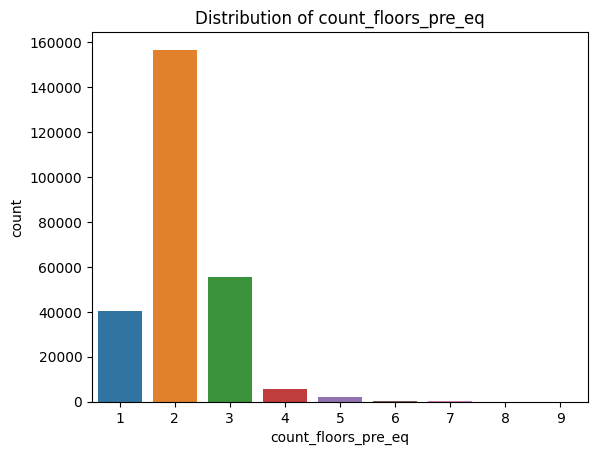

In [17]:
# Plotting the distribution
sns.countplot(data=train_df, x='count_floors_pre_eq')
plt.title("Distribution of count_floors_pre_eq")
plt.savefig('../reports/figures/count_floors_pre_eq_distribution.svg')
plt.show()

## 1. Analysis for `building_id`
This feature describes the unique id for each building. For this reason it provides no further information for the predicion model.

## 2. Analysis for `geo_level_1_id`

As the distribution below is showing

In [7]:
train_df.geo_level_1_id.describe()

count    260601.000000
mean         13.900353
std           8.033617
min           0.000000
25%           7.000000
50%          12.000000
75%          21.000000
max          30.000000
Name: geo_level_1_id, dtype: float64

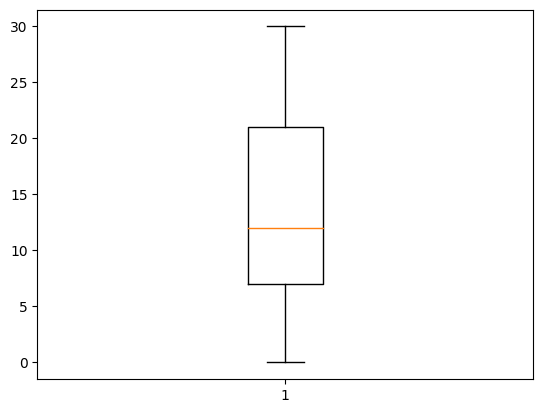

In [8]:
# create a box plot
plt.boxplot(train_df['geo_level_1_id'])
plt.show()

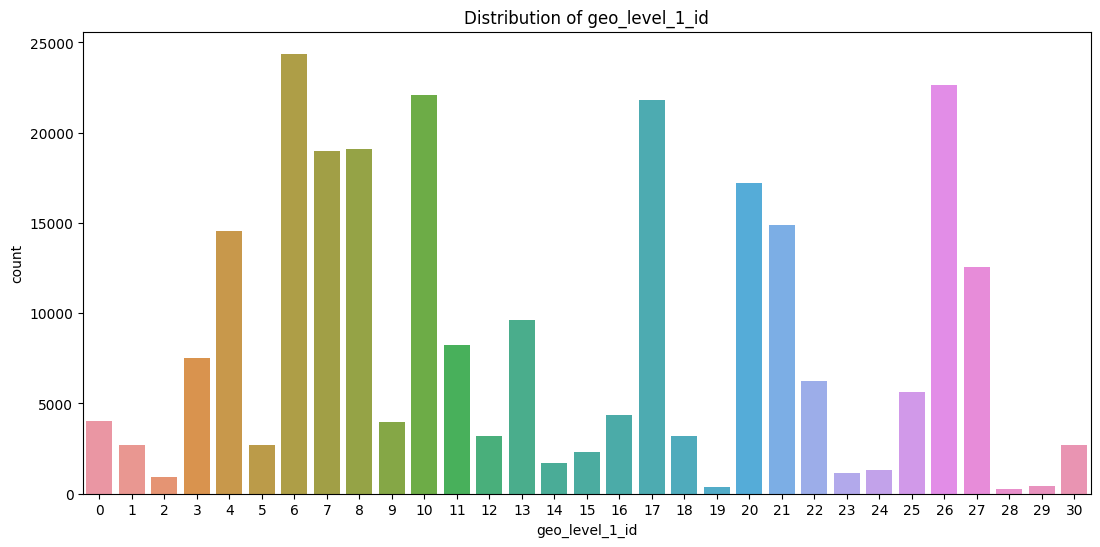

In [9]:
plt.figure(figsize=(13,6))
sns.countplot(data=train_df, x='geo_level_1_id')
plt.title("Distribution of geo_level_1_id")
plt.show()

In [10]:
#outliers = build_features.find_outliers_IQR(train_df.select_dtypes(include='number'))
outliers = build_features.find_outliers_IQR(train_df['geo_level_1_id'])

print('number of outliers: ' + str(len(outliers)))

print('max outlier value: ' + str(outliers.max()))

print('min outlier value: ' + str(outliers.min()))


number of outliers: 0
max outlier value: nan
min outlier value: nan


-------------

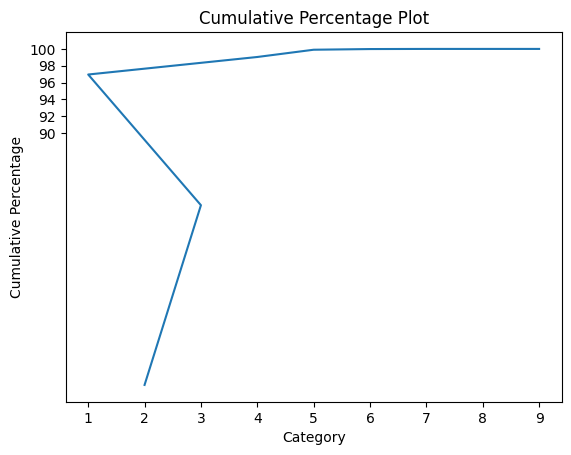

In [11]:
cumulative_sum = train_df['count_floors_pre_eq'].value_counts().sort_values(ascending=False).cumsum()

cumulative_percentage = 100 * cumulative_sum / cumulative_sum.max()

# plot the cumulative percentage
plt.plot(cumulative_percentage.index, cumulative_percentage)

# set the plot title and axis labels
plt.title('Cumulative Percentage Plot')
plt.xlabel('Category')
plt.ylabel('Cumulative Percentage')
yticks = np.arange(90, 102,2)
ylabels = [f"{y:.0f}%" for y in yticks]
plt.yticks(yticks)
# show the plot
plt.show()